# Sentiment Analysis Model for Wuthering Waves Google Play Reviews

**Author:** Michael Teguh Carlo Simbolon  
**Cohort ID:** MS155D5Y0583  
**Date:** March 10, 2025

## Project Overview

This notebook performs sentiment analysis on Google Play Store reviews for the game "Wuthering Waves". 
We explore and compare multiple approaches:

1. Traditional ML with TF-IDF + SVM
2. Deep Learning with Word Embeddings + LSTM
3. Traditional ML with TF-IDF + Random Forest

The goal is to classify reviews into three sentiment categories (positive, neutral, negative) with over 92% accuracy.

## 1. Setup and Import Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Data Loading and Exploration

Let's load the dataset containing reviews and perform some initial exploration to understand what we're working with.

In [2]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv('dataset.csv')  # Adjust the file name as needed
print(f"Dataset loaded with {len(df)} samples.")

# Display the first few rows
print("\nSample data:")
display(df.head())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

Loading dataset...
Dataset loaded with 10000 samples.

Sample data:


,Text,Rating,Tanggal,Username,Label Sentimen
0,sangat seru untuk di mainkan,5,2025-03-05 18:25:36,Ujek Uzairin rahman,positif
1,seruu!!,5,2025-03-05 16:32:55,Leth Kreiburg,positif
2,setelah update game jadi lebih lag dan suka dr...,3,2025-03-05 16:03:48,Kenkiro ቿ,netral
3,Ko download data nya lama banget ya padahal ja...,4,2025-03-05 15:53:04,Gunawan 123,positif
4,Best game,5,2025-03-05 14:26:41,Kiy,positif



Missing values:


Text              0
Rating            0
Tanggal           0
Username          0
Label Sentimen    0
dtype: int64

## 3. Data Preprocessing

We'll clean and prepare the text data for our models. This includes:
- Converting to lowercase
- Removing special characters
- Tokenization
- Removing stopwords (in Indonesian)

In [3]:
def preprocess_text(text):
    """
    Clean and preprocess text data.
    
    Parameters:
    -----------
    text : str
        Raw text input
        
    Returns:
    --------
    str
        Cleaned and preprocessed text
    """
    # Handle missing values
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords (Indonesian)
    stop_words = set(stopwords.words('indonesian'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into string
    return ' '.join(tokens)

# Apply preprocessing
print("Preprocessing text data...")
df['Processed_Text'] = df['Text'].apply(preprocess_text)
print("Text preprocessing completed.")

# Display sample of processed text
print("\nSample of processed text:")
for i in range(3):
    print(f"Original: {df['Text'].iloc[i]}")
    print(f"Processed: {df['Processed_Text'].iloc[i]}")
    print()

Preprocessing text data...
Text preprocessing completed.

Sample of processed text:
Original: sangat seru untuk di mainkan
Processed: seru mainkan

Original: seruu!!
Processed: seruu

Original: setelah update game jadi lebih lag dan suka drop fps
Processed: update game lag suka drop fps



## 4. Exploratory Data Analysis

Let's analyze the distribution of sentiment classes and text characteristics.

Sentiment class distribution:


Label Sentimen
positif    7409
negatif    1965
netral      626
Name: count, dtype: int64

C:\Users\USER\AppData\Local\Temp\ipykernel_26692\2403960833.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label Sentimen', data=df, palette='viridis')


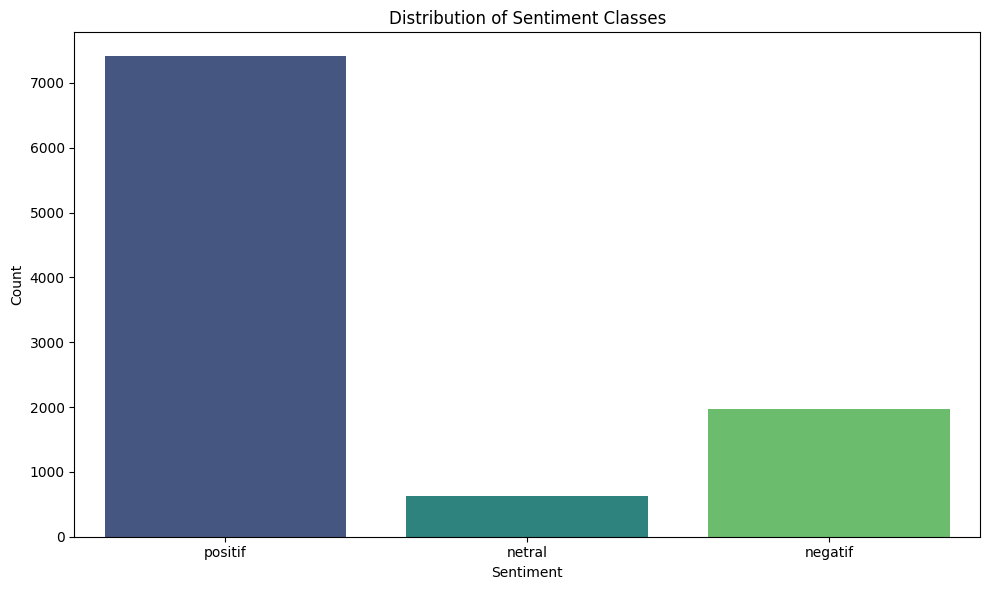

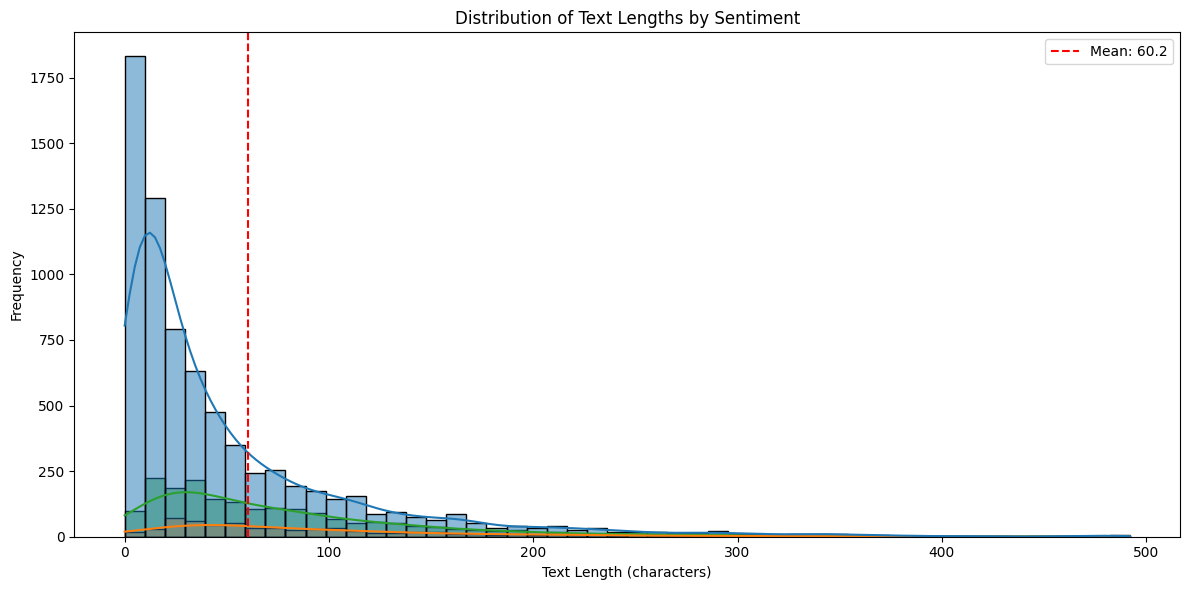

In [4]:
# Check class distribution
print("Sentiment class distribution:")
sentiment_counts = df['Label Sentimen'].value_counts()
display(sentiment_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Label Sentimen', data=df, palette='viridis')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate text length statistics
df['text_length'] = df['Processed_Text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='Label Sentimen', bins=50, kde=True)
plt.title('Distribution of Text Lengths by Sentiment')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.axvline(x=df['text_length'].mean(), color='r', linestyle='--', label=f'Mean: {df["text_length"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Feature Engineering

We'll prepare our features for both traditional ML and deep learning approaches.

In [5]:
# Define Features and Labels
X = df['Processed_Text']
y = df['Label Sentimen'].map({'positif': 2, 'netral': 1, 'negatif': 0})  # Encode labels

# TF-IDF Vectorization for traditional ML approaches
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X).toarray()
print(f"TF-IDF feature shape: {X_tfidf.shape}")

# Text sequence preparation for LSTM
print("\nCreating sequence features for deep learning...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100)
print(f"Sequence feature shape: {X_pad.shape}")

# Display vocabulary size
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)} words")

Creating TF-IDF features...
TF-IDF feature shape: (10000, 5000)

Creating sequence features for deep learning...
Sequence feature shape: (10000, 100)
Vocabulary size: 10235 words


## 6. Experiment 1: TF-IDF + SVM (80/20 Split)

We'll use Support Vector Machines with TF-IDF features to classify sentiment.

=== Experiment 1: TF-IDF + SVM (80/20 Split) ===
Training set: 8000 samples
Test set: 2000 samples

Training SVM model...
SVM model training completed.

Evaluating SVM model...
SVM Accuracy: 0.8170

Classification Report:
              precision    recall  f1-score   support

     negatif       0.68      0.55      0.61       399
      netral       0.00      0.00      0.00       123
     positif       0.84      0.96      0.90      1478

    accuracy                           0.82      2000
   macro avg       0.51      0.50      0.50      2000
weighted avg       0.76      0.82      0.78      2000



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

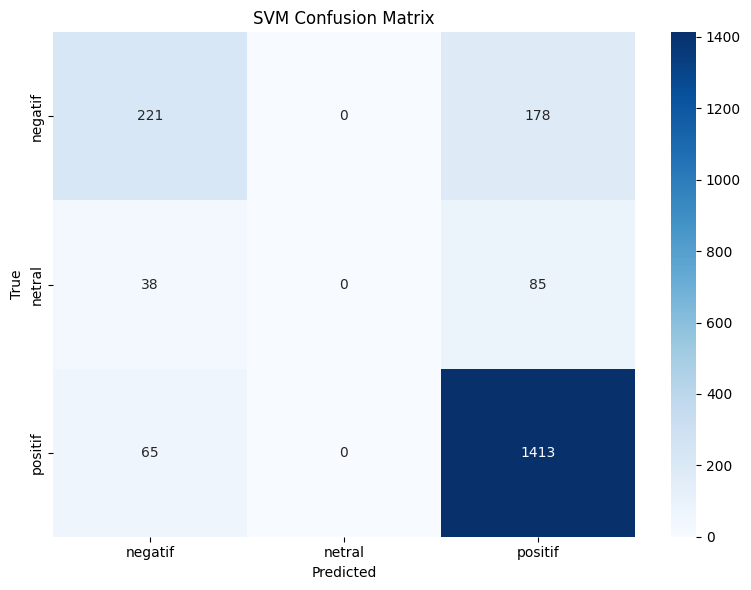

In [6]:
print("=== Experiment 1: TF-IDF + SVM (80/20 Split) ===")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train SVM model
print("\nTraining SVM model...")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
print("SVM model training completed.")

# Evaluate
print("\nEvaluating SVM model...")
y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_acc:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['negatif', 'netral', 'positif']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'], 
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## 7. Experiment 2: Word Embedding + LSTM (80/20 Split)

Now we'll use a deep learning approach with LSTM network and word embeddings.

=== Experiment 2: Word Embedding + LSTM (80/20 Split) ===
Training set: 8000 samples
Test set: 2000 samples

Building LSTM model...
LSTM model architecture:


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.7226 - loss: 0.7361 - val_accuracy: 0.7669 - val_loss: 0.6053
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7869 - loss: 0.5409 - val_accuracy: 0.7906 - val_loss: 0.5470
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8356 - loss: 0.4319 - val_accuracy: 0.7994 - val_loss: 0.5506
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8688 - loss: 0.3539 - val_accuracy: 0.7956 - val_loss: 0.5840
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8976 - loss: 0.3006 - val_accuracy: 0.7906 - val_loss: 0.6323
LSTM model training completed.

Evaluating LSTM model...
LSTM Test Loss: 0.5131
LSTM Test Accuracy: 0.8025
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Classification Report:
              precision    recall  f1-score   support

     negatif       0.62      0.53      0.57       399
      netral       0.00      0.00      0.00       

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

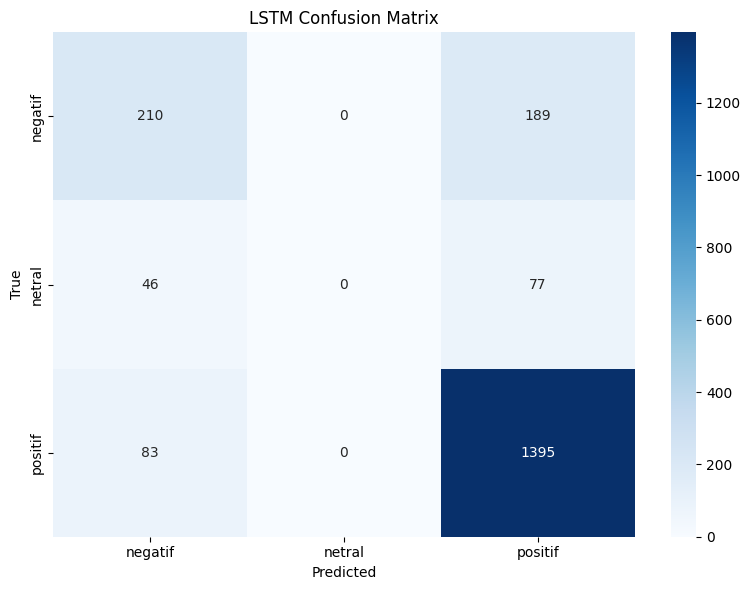

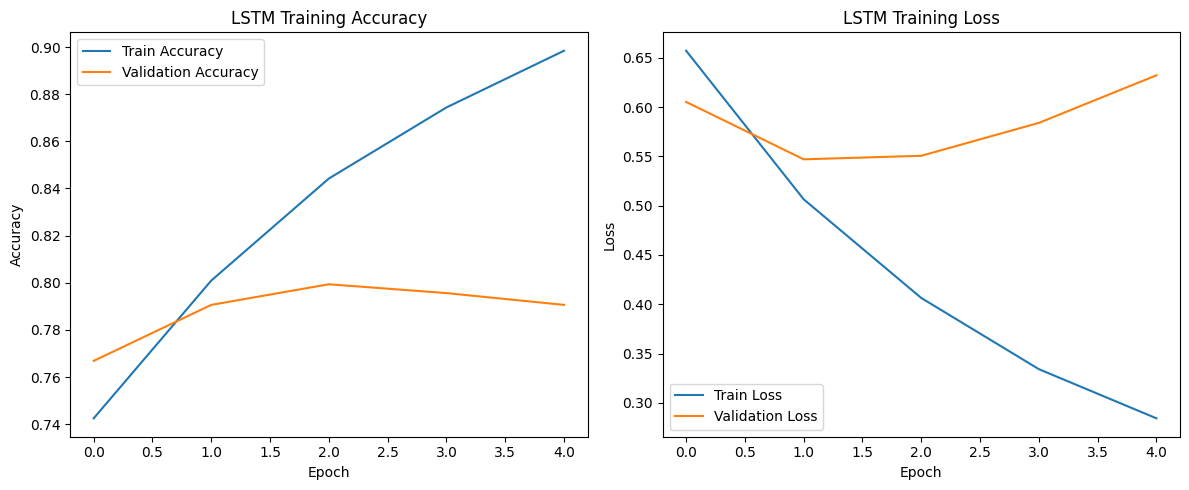

In [7]:
print("=== Experiment 2: Word Embedding + LSTM (80/20 Split) ===")

# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train_lstm.shape[0]} samples")
print(f"Test set: {X_test_lstm.shape[0]} samples")

# Build LSTM model
print("\nBuilding LSTM model...")
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("LSTM model architecture:")
lstm_model.summary()

# Set up early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train LSTM
print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)
print("LSTM model training completed.")

# Evaluate
print("\nEvaluating LSTM model...")
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"LSTM Test Loss: {lstm_loss:.4f}")
print(f"LSTM Test Accuracy: {lstm_acc:.4f}")

y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print("\nClassification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=['negatif', 'netral', 'positif']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_lstm, y_pred_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'], 
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 8. Experiment 3: TF-IDF + Random Forest (70/30 Split)

Finally, we'll try a Random Forest approach with a different train/test split ratio.

=== Experiment 3: TF-IDF + Random Forest (70/30 Split) ===
Training set: 7000 samples
Test set: 3000 samples

Training Random Forest model...
Random Forest model training completed.

Evaluating Random Forest model...
Random Forest Accuracy: 0.7963

Classification Report:
              precision    recall  f1-score   support

     negatif       0.64      0.43      0.51       593
      netral       0.00      0.00      0.00       179
     positif       0.82      0.96      0.88      2228

    accuracy                           0.80      3000
   macro avg       0.49      0.46      0.47      3000
weighted avg       0.74      0.80      0.76      3000



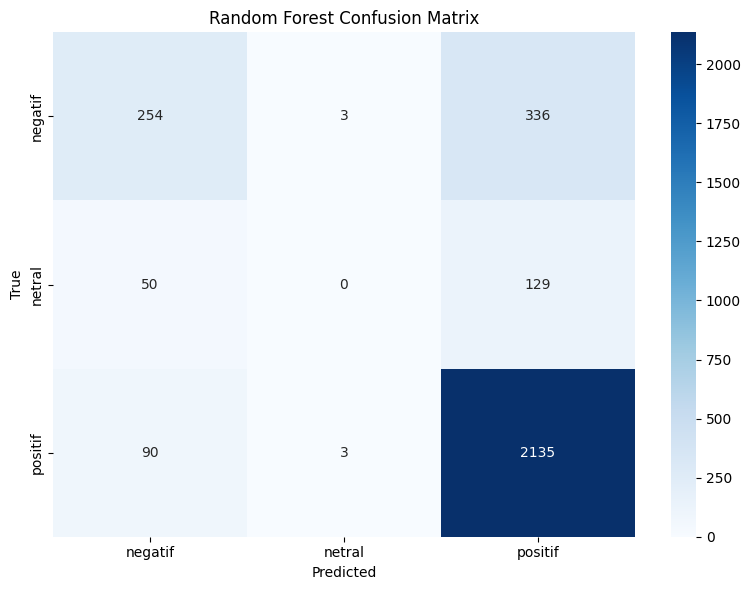

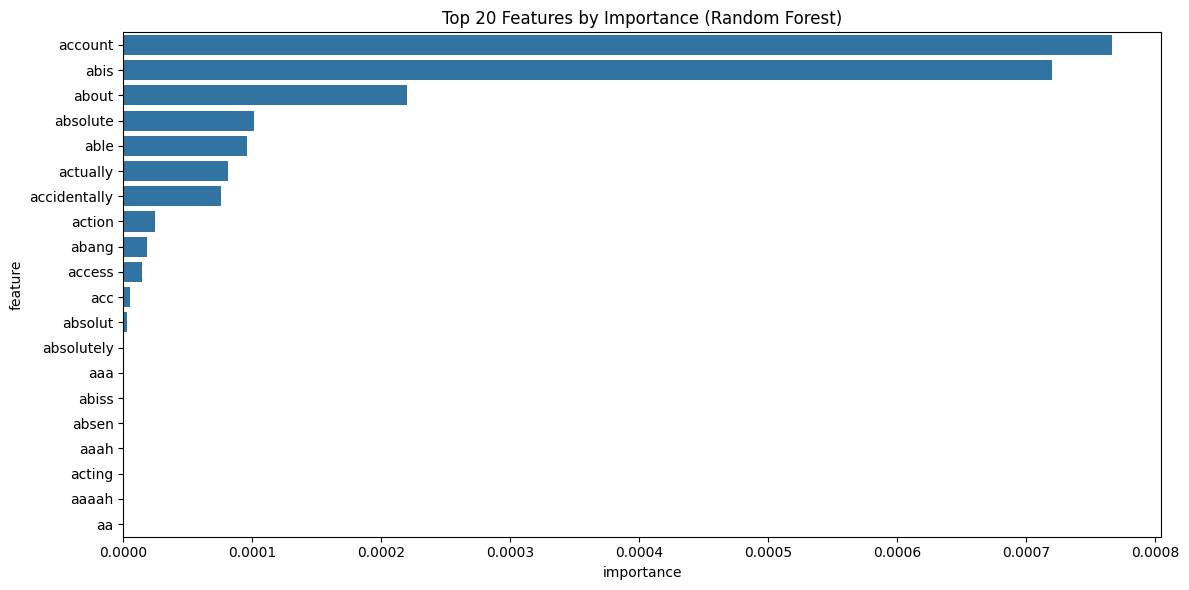

In [8]:
print("=== Experiment 3: TF-IDF + Random Forest (70/30 Split) ===")

# Different train/test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)
print(f"Training set: {X_train_rf.shape[0]} samples")
print(f"Test set: {X_test_rf.shape[0]} samples")

# Train Random Forest
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)
print("Random Forest model training completed.")

# Evaluate
print("\nEvaluating Random Forest model...")
y_pred_rf = rf_model.predict(X_test_rf)
rf_acc = accuracy_score(y_test_rf, y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=['negatif', 'netral', 'positif']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_rf, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negatif', 'netral', 'positif'], 
            yticklabels=['negatif', 'netral', 'positif'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Feature importance
plt.figure(figsize=(12, 6))
feature_importances = pd.DataFrame({
    'feature': tfidf.get_feature_names_out()[:20],  # Get top 20 features
    'importance': rf_model.feature_importances_[:20]
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Top 20 Features by Importance (Random Forest)')
plt.tight_layout()
plt.show()

## 9. Model Deployment: Creating Inference Function

Let's create a function that makes it easy to predict sentiment for new reviews using any of our trained models.

In [9]:
def predict_sentiment(text, model_type='lstm'):
    """
    Predict sentiment for new text input using the specified model.
    
    Parameters:
    -----------
    text : str
        Raw text input to analyze
    model_type : str
        Type of model to use ('lstm', 'svm', or 'rf')
        
    Returns:
    --------
    str
        Predicted sentiment ('positif', 'netral', 'negatif')
    float
        Confidence score (probability) for the prediction
    """
    # Preprocess the input text
    processed_text = preprocess_text(text)
    
    # Map of numerical labels to sentiment classes
    label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}
    
    if model_type == 'lstm':
        # Process for LSTM model
        seq = tokenizer.texts_to_sequences([processed_text])
        padded = pad_sequences(seq, maxlen=100)
        pred_probs = lstm_model.predict(padded)[0]
        pred_label = np.argmax(pred_probs)
        confidence = pred_probs[pred_label]
        
    elif model_type == 'svm':
        # Process for SVM model
        tfidf_text = tfidf.transform([processed_text]).toarray()
        pred_label = svm_model.predict(tfidf_text)[0]
        confidence = np.max(svm_model.predict_proba(tfidf_text)[0])
        
    elif model_type == 'rf':
        # Process for Random Forest model
        tfidf_text = tfidf.transform([processed_text]).toarray()
        pred_label = rf_model.predict(tfidf_text)[0]
        confidence = np.max(rf_model.predict_proba(tfidf_text)[0])
        
    else:
        raise ValueError("Model type must be 'lstm', 'svm', or 'rf'")
    
    return label_map[pred_label], confidence

## 10. Testing Inference on Sample Reviews

Let's test our sentiment prediction function on some sample reviews.

In [10]:
# Example reviews to test
sample_reviews = [
    "Game ini sangat seru dan grafisnya bagus!",
    "Biasa saja, tidak terlalu menarik.",
    "Banyak bug, sangat mengecewakan.",
    "Gameplay cukup menarik tapi masih ada beberapa masalah teknis.",
    "Karakter dan cerita sangat menarik, saya sangat menikmati permainan ini!"
]

# Create a table to compare results from all models
results = []

print("=== Inference Examples ===")
for review in sample_reviews:
    # Get predictions from each model
    lstm_pred, lstm_conf = predict_sentiment(review, 'lstm')
    svm_pred, svm_conf = predict_sentiment(review, 'svm')
    rf_pred, rf_conf = predict_sentiment(review, 'rf')
    
    # Add to results
    results.append({
        'Review': review,
        'LSTM Prediction': lstm_pred,
        'LSTM Confidence': f"{lstm_conf:.4f}",
        'SVM Prediction': svm_pred,
        'SVM Confidence': f"{svm_conf:.4f}",
        'RF Prediction': rf_pred,
        'RF Confidence': f"{rf_conf:.4f}"
    })

# Display comparison table
display(pd.DataFrame(results))

=== Inference Examples ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


,Review,LSTM Prediction,LSTM Confidence,SVM Prediction,SVM Confidence,RF Prediction,RF Confidence
0,Game ini sangat seru dan grafisnya bagus!,positif,0.9944,positif,0.9665,positif,1.0000
1,"Biasa saja, tidak terlalu menarik.",positif,0.9680,positif,0.9347,positif,0.9991
2,"Banyak bug, sangat mengecewakan.",negatif,0.5888,negatif,0.6109,positif,0.5250
3,Gameplay cukup menarik tapi masih ada beberapa...,positif,0.9345,positif,0.8204,positif,0.9372
4,"Karakter dan cerita sangat menarik, saya sanga...",positif,0.9251,positif,0.8204,positif,0.9095


## 11. Summary and Conclusion

Let's summarize our findings and compare the performance of our models.

=== Summary of Results ===


,Model,Accuracy,Split Ratio,Feature Type
0,SVM + TF-IDF (80/20),0.8170,80/20,TF-IDF
1,LSTM + Embedding (80/20),0.8025,80/20,Word Embedding
2,RF + TF-IDF (70/30),0.7963,70/30,TF-IDF


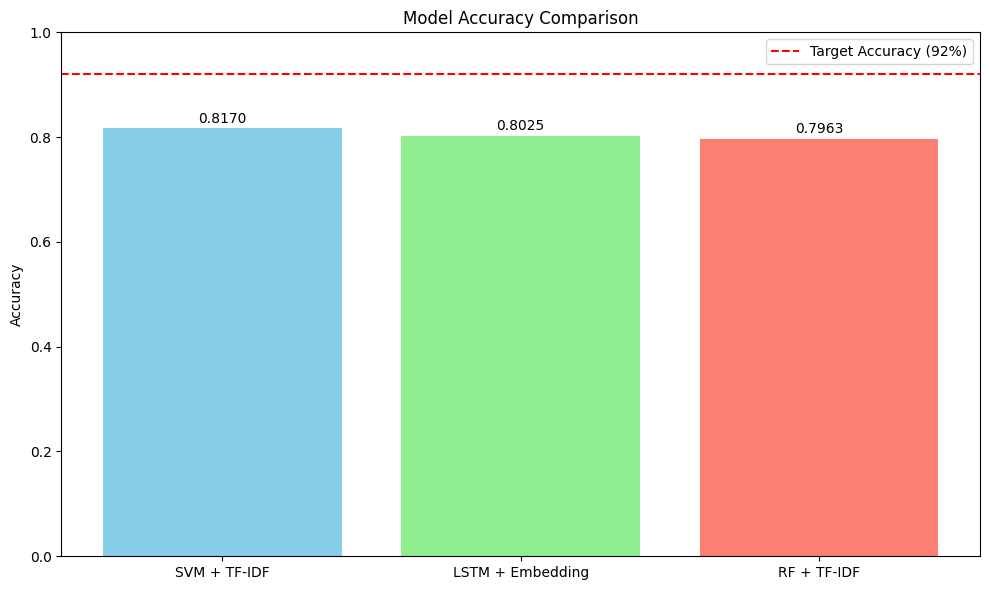

In [11]:
# Create summary table
summary_data = {
    'Model': ['SVM + TF-IDF (80/20)', 'LSTM + Embedding (80/20)', 'RF + TF-IDF (70/30)'],
    'Accuracy': [svm_acc, lstm_acc, rf_acc],
    'Split Ratio': ['80/20', '80/20', '70/30'],
    'Feature Type': ['TF-IDF', 'Word Embedding', 'TF-IDF']
}

summary_df = pd.DataFrame(summary_data)
summary_df['Accuracy'] = summary_df['Accuracy'].apply(lambda x: f"{x:.4f}")

# Display summary
print("=== Summary of Results ===")
display(summary_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
accuracies = [svm_acc, lstm_acc, rf_acc]
model_names = ['SVM + TF-IDF', 'LSTM + Embedding', 'RF + TF-IDF']

bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.axhline(y=0.92, color='r', linestyle='--', label='Target Accuracy (92%)')

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## 12. Future Improvements

Based on our results, here are some potential improvements for future work:

1. **Data Augmentation**: Generate more training samples to improve model robustness

2. **Advanced Models**: Implement transformer-based models like BERT or GPT for Indonesian language

3. **Hyperparameter Tuning**: Optimize model parameters using grid search or Bayesian optimization

4. **Ensemble Methods**: Combine predictions from multiple models for better performance

5. **Cross-Validation**: Use k-fold cross-validation for more reliable performance metrics

6. **Feature Engineering**: Explore n-grams, POS tagging, or custom features specific to game reviews